#### Import packages

In [105]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer

In [106]:
train_data = pd.read_csv('train_data.csv',index_col=0)
test_data = pd.read_csv('test_data.csv',index_col=0)
train_data.index = range(len(train_data))
train_data.loc[train_data['OCCUPATION']!=1,'OCCUPATION'] = 0
test_data.index = range(len(test_data))
test_data.loc[test_data['OCCUPATION']!=1,'OCCUPATION'] = 0

Prepare the data

In [107]:
# first, we list all the categorical variables to be one hot encoded
cat_vars = ['MARRIAGE', 'EDUCATION']

In [108]:
# create an encoder for each cat_vars
encoders = [OneHotEncoder(categories='auto') for _ in range(len(cat_vars))] 
# encode each of the cat_vars with their respective encoder
encoded_tr = [encoders[i].fit_transform(train_data[[cat_var]]).todense() for i,cat_var in enumerate(cat_vars)]
encoded_test = [encoders[i].fit_transform(test_data[[cat_var]]).todense() for i,cat_var in enumerate(cat_vars)]

In [109]:
# drop the label column and also drop the cat_vars 
# this way we can combine the encoded categorical variables with the continuous variables 
X_train = pd.concat([train_data.iloc[:,:-1].drop(cat_vars, axis=1), 
                     pd.DataFrame(np.concatenate(encoded_tr, axis=1))], axis=1)
X_test = pd.concat([test_data.iloc[:,:-1].drop(cat_vars, axis=1), 
                    pd.DataFrame(np.concatenate(encoded_test, axis=1))], axis=1)
y_train = train_data.iloc[:,-1] 
y_test = test_data.iloc[:,-1]
X_train = X_train.rename(columns={0:'Marriage 1',1:'Marriage 2',2:'Marriage 3',3:'Edu 1',4:'Edu 2',5:'Edu 3',
                                  6:'Edu 4',7:'Edu 5',8:'Edu 6',9:'Edu 7'})
# Note that in the testing data, we do not have Marriage 3 and Edu 6
X_test = X_test.rename(columns={0:'Marriage 1',1:'Marriage 2',2:'Edu 1',3:'Edu 2',4:'Edu 3',
                                  5:'Edu 4',6:'Edu 5',7:'Edu 7'})
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

Normalize continuous variables

In [110]:
for i in [0,1,2,3,4,5,8]:
    X1 = X_train.iloc[:,i]
    mean = X1.mean()
    std = X1.std()
    X_train.iloc[:,i] = (X1-mean)/std
    X_test.iloc[:,i] = (X_test.iloc[:,i]-mean)/std

In [111]:
# Get rid of some dummy variables to avoid perfect multicollinearity
X_train = X_train.drop(['Marriage 3','Edu 6'], axis=1)

Import classifiers for analysis

In [112]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# List of models
models = []
models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
models.append(('Logistic Regression', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier(random_state=0)))
models.append(('XGBoost', XGBClassifier(random_state=0, objective='binary:logistic')))

In [113]:
for classifier, model in models:
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy = accuracy_score(y_train,y_train_pred)
    test_accuracy = accuracy_score(y_test,y_test_pred)
    TN, FP, FN, TP = confusion_matrix(y_test,y_test_pred,sample_weight=None).ravel()
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    print("Classifier: {}".format(classifier))    
    print("Accuracy Score on Training Data = {:.4f}".format(train_accuracy))    
    print("Performance on Testing Data:")
    print("Accuracy Score = {:.4f}".format(test_accuracy))    
    print("True Positive Rate = {:.4f}".format(TPR))
    print("True Negative Rate = {:.4f}".format(TNR))
    print("\n")

Classifier: Linear Discriminant Analysis
Accuracy Score on Training Data = 0.8600
Performance on Testing Data:
Accuracy Score = 0.8609
True Positive Rate = 0.8654
True Negative Rate = 0.8571


Classifier: Logistic Regression
Accuracy Score on Training Data = 0.8691
Performance on Testing Data:
Accuracy Score = 0.8522
True Positive Rate = 0.8462
True Negative Rate = 0.8571


Classifier: KNN
Accuracy Score on Training Data = 0.8582
Performance on Testing Data:
Accuracy Score = 0.8522
True Positive Rate = 0.7692
True Negative Rate = 0.9206


Classifier: Decision Tree
Accuracy Score on Training Data = 1.0000
Performance on Testing Data:
Accuracy Score = 0.8783
True Positive Rate = 0.8269
True Negative Rate = 0.9206


Classifier: XGBoost
Accuracy Score on Training Data = 1.0000
Performance on Testing Data:
Accuracy Score = 0.8696
True Positive Rate = 0.8269
True Negative Rate = 0.9048




### Let's tune the hyperparamters

In [114]:
# Store the metrics in results dictionary
result = {}

Linear Discriminant Analysis (LDA):

In [115]:
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None, priors=[0.5,0.5])
lda.fit(X_train, y_train)
y_test_pred = lda.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
TN, FP, FN, TP = confusion_matrix(y_test,y_test_pred,sample_weight=None).ravel()
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
Q = lda.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)    
result['Linear Discriminant Analysis'] = {'Test Accuracy': '{:.4f}'.format(test_accuracy),
                                          'True Positive Rate': '{:.4f}'.format(TPR), 
                                          'True Negative Rate': '{:.4f}'.format(TNR), 
                                          'AUC': '{:.4f}'.format(roc_auc)}
print("Performance on Testing Data:")
print("Accuracy Score = {:.4f}".format(test_accuracy))    
print("True Positive Rate = {:.4f}".format(TPR))
print("True Negative Rate = {:.4f}".format(TNR))
print("AUC = {:.4f}".format(roc_auc))

Performance on Testing Data:
Accuracy Score = 0.8609
True Positive Rate = 0.8654
True Negative Rate = 0.8571
AUC = 0.9209


confusion matrix and ROC curve

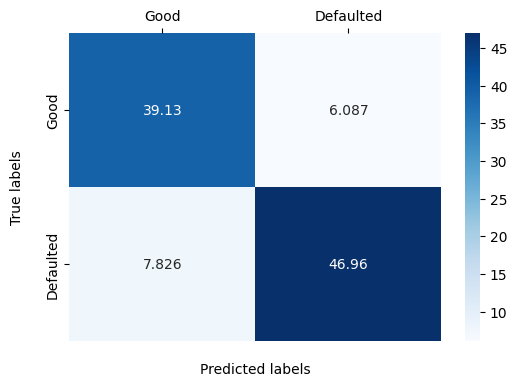

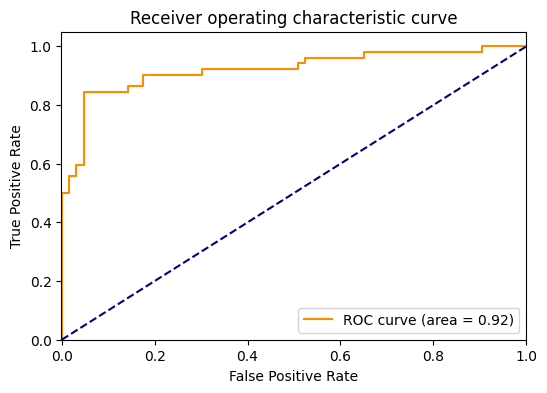

In [116]:
n_test = y_test.shape
cm = (confusion_matrix(y_test,y_test_pred,labels=[1, 0],sample_weight=None)/n_test)*100
plt.figure(figsize=(6, 4))      # format the plot size
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='.4g', cmap="Blues")
ax.set_xlabel('\nPredicted labels'); ax.set_ylabel('True labels\n')
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['Good','Defaulted'],verticalalignment='center')
ax.xaxis.set_ticklabels(['Good','Defaulted'])
plt.show()

plt.figure(figsize=(6,4))      # format the plot size
lw = 1.5
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

Logistic Regression:

In [117]:
lgr_param_grid = {'C': np.linspace(0.05,5,100)}
lgr = LogisticRegression(penalty='l2')
clf_lgr = GridSearchCV(lgr, lgr_param_grid, cv=3)
clf_lgr.fit(X_train, y_train)
lgr_reg_params = clf_lgr.best_params_['C']
print("Best regularization parameter = {:.3f}".format(lgr_reg_params))
lgr = LogisticRegression(penalty='l2',C=lgr_reg_params)
lgr.fit(X_train,y_train)                                                       
y_test_pred = lgr.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
TN, FP, FN, TP = confusion_matrix(y_test,y_test_pred,sample_weight=None).ravel()
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
Q = lgr.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)    
result['Logistic Regression'] = {'Test Accuracy': '{:.4f}'.format(test_accuracy),
                                 'True Positive Rate': '{:.4f}'.format(TPR), 
                                 'True Negative Rate': '{:.4f}'.format(TNR), 
                                 'AUC': '{:.4f}'.format(roc_auc)}
print("Performance on Testing Data:")
print("Accuracy Score = {:.4f}".format(test_accuracy))    
print("True Positive Rate = {:.4f}".format(TPR))
print("True Negative Rate = {:.4f}".format(TNR))
print("AUC = {:.4f}".format(roc_auc))

Best regularization parameter = 0.300
Performance on Testing Data:
Accuracy Score = 0.8696
True Positive Rate = 0.8462
True Negative Rate = 0.8889
AUC = 0.9261


ROC Curve:

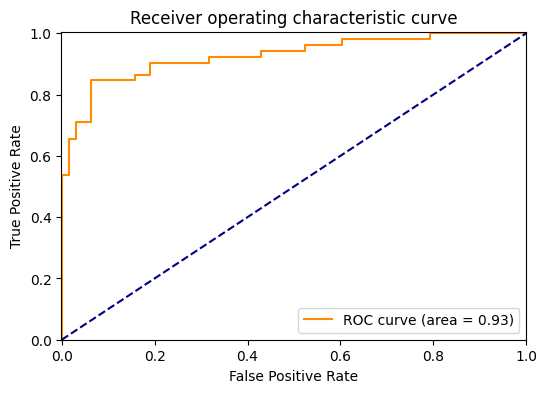

In [118]:
plt.figure(figsize=(6,4))      # format the plot size
lw = 1.5
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.001, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

K Nearest Neighbors:

In [119]:
knn_param_grid = {'n_neighbors': list(range(1, 10))}
knn = KNeighborsClassifier()
clf_knn = GridSearchCV(knn, knn_param_grid, cv = 3)
clf_knn.fit(X_train, y_train)
print("Best k = {}".format(clf_knn.best_params_['n_neighbors']))
knn = clf_knn.best_estimator_
knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
TN, FP, FN, TP = confusion_matrix(y_test,y_test_pred,sample_weight=None).ravel()
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
Q = knn.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)  
result['K Nearest Neighbors'] = {'Test Accuracy': '{:.4f}'.format(test_accuracy),
                                 'True Positive Rate': '{:.4f}'.format(TPR), 
                                 'True Negative Rate': '{:.4f}'.format(TNR), 
                                 'AUC': '{:.4f}'.format(roc_auc)}  
print("Performance on Testing Data:")
print("Accuracy Score = {:.4f}".format(test_accuracy))    
print("True Positive Rate = {:.4f}".format(TPR))
print("True Negative Rate = {:.4f}".format(TNR))
print("AUC = {:.4f}".format(roc_auc))

Best k = 7
Performance on Testing Data:
Accuracy Score = 0.8609
True Positive Rate = 0.7885
True Negative Rate = 0.9206
AUC = 0.9089


Confusion Matrix and ROC Curve:

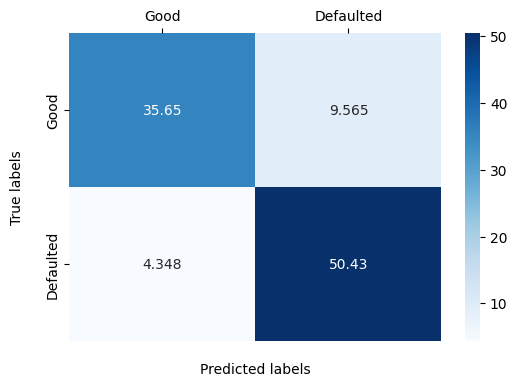

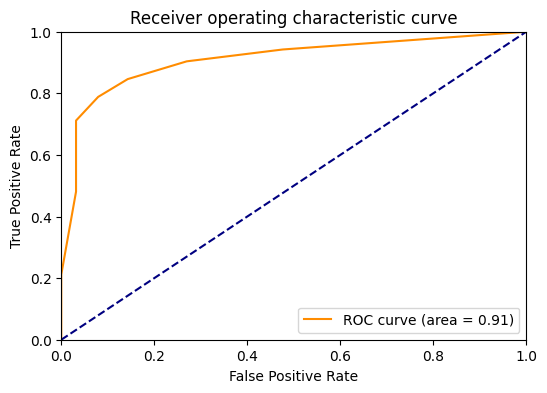

In [120]:
n_test = y_test.shape
cm = (confusion_matrix(y_test,y_test_pred,labels=[1, 0],sample_weight=None)/n_test)*100
plt.figure(figsize=(6, 4))      # format the plot size
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='.4g', cmap="Blues")
ax.set_xlabel('\nPredicted labels'); ax.set_ylabel('True labels\n')
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['Good','Defaulted'],verticalalignment='center')
ax.xaxis.set_ticklabels(['Good','Defaulted'])
plt.show()

plt.figure(figsize=(6,4))      # format the plot size
lw = 1.5
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

Decision Tree:

In [121]:
dtree_param_grid = {'max_depth': list(range(3, 10))}
dtree = DecisionTreeClassifier(random_state=0)
clf_dtree = GridSearchCV(dtree, dtree_param_grid, cv=3)
clf_dtree.fit(X_train, y_train)
dtree = clf_dtree.best_estimator_
dtree.fit(X_train,y_train)
y_test_pred = dtree.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
TN, FP, FN, TP = confusion_matrix(y_test,y_test_pred,sample_weight=None).ravel()
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
Q = dtree.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)    
result['Decision Tree'] = {'Test Accuracy': '{:.4f}'.format(test_accuracy),
                           'True Positive Rate': '{:.4f}'.format(TPR), 
                           'True Negative Rate': '{:.4f}'.format(TNR), 
                           'AUC': '{:.4f}'.format(roc_auc)}
print("Performance on Testing Data:")
print("Accuracy Score = {:.4f}".format(test_accuracy))    
print("True Positive Rate = {:.4f}".format(TPR))
print("True Negative Rate = {:.4f}".format(TNR))
print("AUC = {:.4f}".format(roc_auc))

Performance on Testing Data:
Accuracy Score = 0.8783
True Positive Rate = 0.8269
True Negative Rate = 0.9206
AUC = 0.9153


Confusion Matrix and ROC Curve:

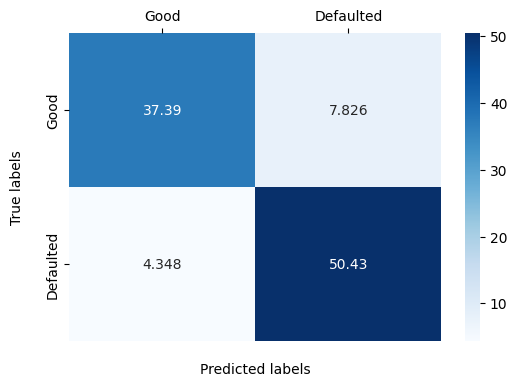

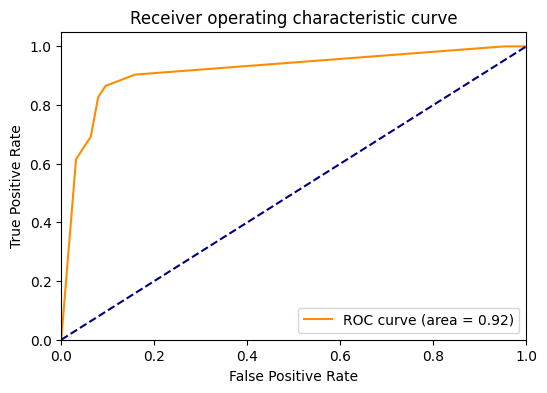

In [122]:
n_test = y_test.shape
cm = (confusion_matrix(y_test,y_test_pred,labels=[1, 0],sample_weight=None)/n_test)*100
plt.figure(figsize=(6, 4))      # format the plot size
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='.4g', cmap="Blues")
ax.set_xlabel('\nPredicted labels'); ax.set_ylabel('True labels\n')
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['Good','Defaulted'],verticalalignment='center')
ax.xaxis.set_ticklabels(['Good','Defaulted'])
plt.show()

plt.figure(figsize=(6,4))      # format the plot size
lw = 1.5
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [123]:
# Display Final Results
results_df = pd.DataFrame(result)
print('Classifer Performance Summary:')
print(results_df)

Classifer Performance Summary:
                   Linear Discriminant Analysis Logistic Regression  \
Test Accuracy                            0.8609              0.8696   
True Positive Rate                       0.8654              0.8462   
True Negative Rate                       0.8571              0.8889   
AUC                                      0.9209              0.9261   

                   K Nearest Neighbors Decision Tree  
Test Accuracy                   0.8609        0.8783  
True Positive Rate              0.7885        0.8269  
True Negative Rate              0.9206        0.9206  
AUC                             0.9089        0.9153  


#### Final recommended model would be Decision Tree due to the highest accuracy and equally high AUC and TNR